In [5]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt3_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [3]:
# Establish connection with database
client = MongoClient()
mydb = client["testinsightdb"]

In [27]:
currcol = mydb['zachlowe_nba']
y = currcol.find({"name": 'zachlowe_nba'})
currcol = mydb['timkawakami']
t = currcol.find({"name": 'timkawakami'})
# print(y[0]['article'])

In [32]:
def clean_text(txtstr):
    txtstr = re.sub(r'\n\s*\n', '', txtstr) # extra lines
    txtstr = re.sub(r'[^\w\s]','',txtstr) # punctuation
    # for numbers
#     txtstr = re.sub(r'[^A-Za-z0-9(),!?@\'\`\"\_\n]', ' ', txtstr)
#     txtstr = re.sub(r'\w*\d\w*','',txtstr) # words with number plust letters
#     remove_digits = str.maketrans('', '', digits)
#     txtstr = txtstr.translate(remove_digits)
    txtstr = re.sub(' +',' ',txtstr) # extra white spaces
    txtstr = txtstr.lower()
    return txtstr

In [36]:
vec = TfidfVectorizer()
vec.fit([clean_text(y[0]['article']), clean_text(y[1]['article']), clean_text(t[1]['article'])])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [44]:
vector1 = vec.transform([clean_text(y[0]['article'])])
vector2 = vec.transform([clean_text(y[15]['article'])])
vector3 = vec.transform([clean_text(t[1]['article'])])
print(np.shape(vector1))
print(np.shape(vector2))
print(np.shape(vector3))

(1, 1415)
(1, 1415)
(1, 1415)


In [45]:
from sklearn.metrics.pairwise import cosine_similarity

result1 = cosine_similarity(vector1, vector2)
result2 = cosine_similarity(vector1, vector3)
print(result1)
print(result2)

[[0.89821625]]
[[0.5884013]]


In [17]:
text = ["The quick brown fox jumped over the lazy dog.",
    "The dog.",
    "The fox"]
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
[1.69314718 1.28768207 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.        ]
(1, 8)
[[0.36388646 0.27674503 0.27674503 0.36388646 0.36388646 0.36388646
  0.36388646 0.42983441]]


In [48]:
data_into_tfidf = []
for curr_name in writer_df['website_name']:
    currcol = mydb[curr_name]
    print(curr_name)
    y = currcol.find({"name": curr_name})
    # iterate through all articles for that author
    idx = 1
    for curr_art in y:
        data_into_tfidf.append(clean_text(curr_art['article']))
        idx += 1
        if idx > 10:
            print('breaking')
            break

zachlowe_nba
breaking
adrian-wojnarowski
breaking
lee-jenkins
breaking
howardbeck
breaking
marc-stein
breaking
ethan-sherwood-strauss
breaking
jason-concepcion
breaking
kevin-arnovitz
breaking
tom-haberstroh
breaking
nate-duncan
breaking
zach-harper
breaking
brian-windhorst
breaking
sam_amick
breaking
david-aldridge
breaking
ramona-shelburne
breaking
jpdabrams
breaking
kevin-pelton
breaking
marc-j-spears
breaking
matt-moore
breaking
shams-charania
breaking
kevin-p-oconnor
breaking
chris-haynes
breaking
dave-mcmenamin
breaking
shea-serrano
breaking
ian-begley
breaking
rachel-nichols
breaking
ben-golliver
breaking
mike-prada
breaking
robmahoney
breaking
tim-macmahon
breaking
chris-herring
breaking
billsimmons
breaking
jonathan-tjarks
breaking
amin-elhassen
bobby-marks
breaking
danny-leroux
breaking
chris-mannix
breaking
dan-devine
breaking
michael-pina
breaking
thompsonscribe
breaking
ben-golliver
breaking
ben-falk
breaking
ian-levy
breaking
tim-bontemps
breaking
henry-abbott
breaking
sc

In [49]:
len(data_into_tfidf)

1088

In [51]:
vec = TfidfVectorizer()
vec.fit(data_into_tfidf)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [53]:
# create vector of each article
output_vec_tf = []
for curr_art in data_into_tfidf:
    output_vec_tf.append(vec.transform([curr_art]))


In [76]:
nvals = 150
matsim = np.ndarray(shape=(nvals,nvals))
for i in range(0,nvals):
    for j in range(0,nvals):
        result1 = cosine_similarity(output_vec_tf[i], output_vec_tf[j])
        matsim[i, j] = result1[0][0]

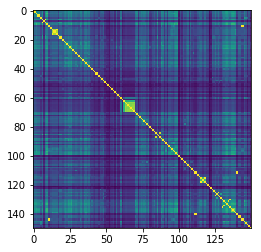

In [77]:
plt.figure
plt.imshow(matsim)